In [1]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
from datetime import datetime, timedelta
import calendar
from matplotlib.ticker import FormatStrFormatter
import pickle
import xarray as xa
import pandas as pd

In [108]:
stations = np.load('../../first-stations.npy')
station_dict = {'10258500':'SC', '10259000':'SC', '10259200':'SC', '10343500':'SN', '11141280':'CC', 
                '11143000':'CC', '11148900':'CC', '11162500':'BA', '11176400':'BA', '11180500':'BA', 
                '11224500':'CC', '11253310':'CC', '11264500':'SN', '11266500':'SN', '11284400':'SN', 
                '11381500':'NC', '11451100':'NC', '11475560':'NC', '11522500':'NC', '11528700':'NC'}
order_stations=[10258500, 10259000, 10259200, 11162500, 11176400,
                10343500, 11264500, 11266500, 11284400, 11180500,
                11141280, 11143000, 11148900, 11224500, 11253310, 
                11381500, 11451100, 11475560, 11522500, 11528700,]
SMALL_SIZE=8; MEDIUM_SIZE=14; BIGGER_SIZE=18
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [97]:
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
start = datetime(1980,1,1)
Hist_date = [start+timedelta(t) for t in hist_date]
def annual_mean(proj, date): ## exclude leap day
    length = proj.shape[0]
    l2 = len(date)
    length = np.min((length, l2))
    data = xa.DataArray(proj[:length].reshape(-1), dims='time', coords={'time': date[:length]})
    month_date_idx = pd.MultiIndex.from_arrays([data['time.month'], data['time.day']])
    data.coords['month_date'] = ('time', month_date_idx)
    # clima_prect = data.groupby('month_date').mean()
    clima_prect = data.groupby('month_date').mean().data
    
    clima_prect = np.delete(clima_prect, 59, axis=0)
    # clima_prect = data.groupby('time.month').mean().data
    return clima_prect

## Histogram

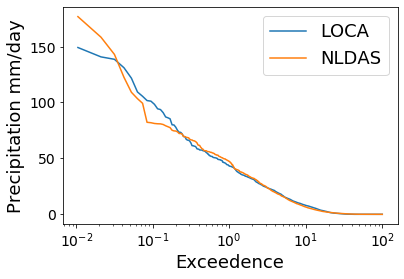

2.74409138766056   2.7440913876605597


In [28]:
regrid_path = '/tempest/duan0000/flow/tem-remap/regrid_out/'
station=11264500
precip = np.load('../../NLDAS_precip_'+str(station)+'.npy')[:9498]
climate_model = 'HadGEM2ES'
p_hist = np.load(regrid_path+str(station)+'_'+climate_model+'_p_hist.npy').reshape(-1, 1)
sort = np.sort(np.clip(p_hist, a_min=1e-10, a_max=None), axis=None)[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)
plt.plot(exceedence*100, sort, label='LOCA')

sort = np.sort(np.clip(precip, a_min=1e-10, a_max=None), axis=None)[::-1]
exceedence = np.arange(1.,len(sort)+1) / len(sort)
plt.plot(exceedence*100, sort, label='NLDAS')
plt.xscale('log')
plt.legend()
plt.xlabel('Exceedence')
plt.ylabel('Precipitation mm/day')
plt.show()
print(np.mean(precip), ' ', np.mean(p_hist))

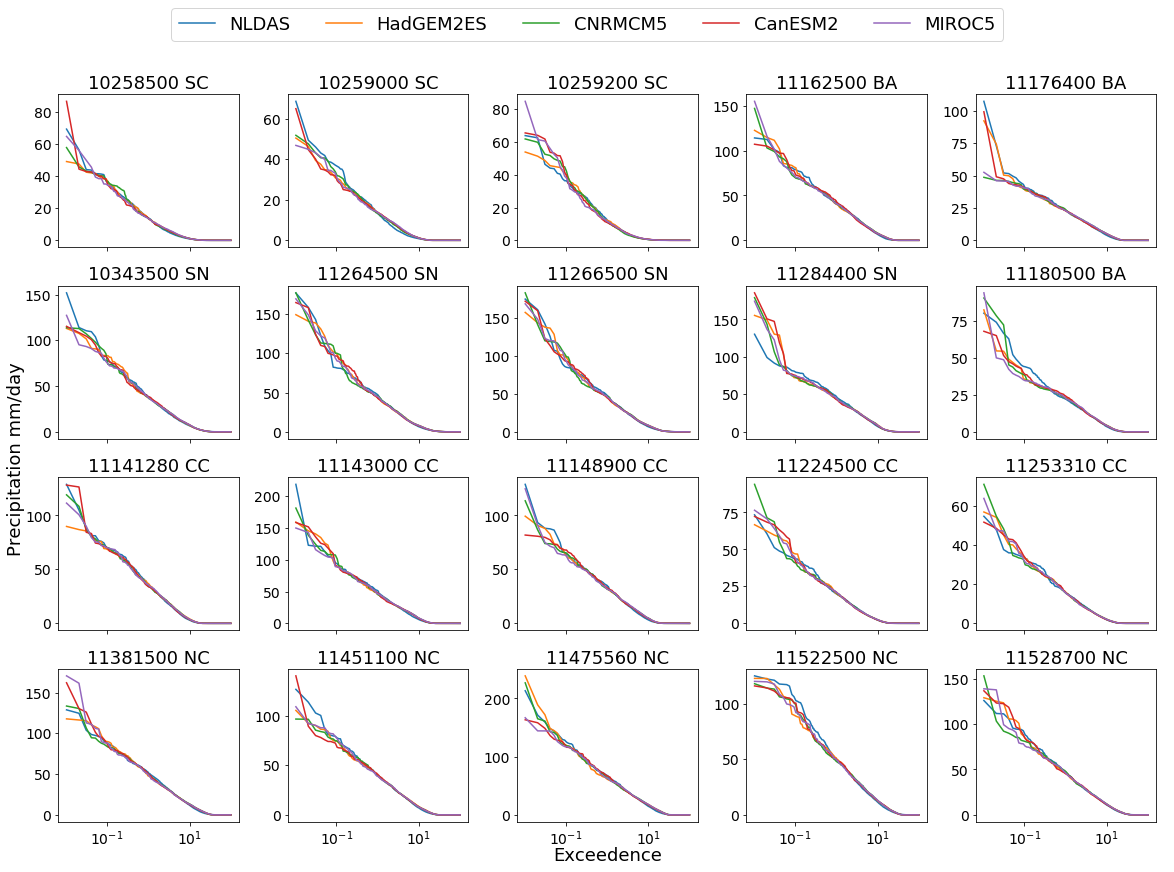

In [34]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
regrid_path = '/tempest/duan0000/flow/tem-remap/regrid_out/'
plt.xlabel("Exceedence")
plt.ylabel("Precipitation mm/day")
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
Hist_date = [start+timedelta(t) for t in hist_date]
i=0

for i in range(20):
    station = order_stations[i]
    ## add observation:
    precip = np.load('../../NLDAS_precip_'+str(station)+'.npy')[:9498]
    sort = np.sort(np.clip(precip, a_min=1e-10, a_max=None), axis=None)[::-1]
    exceedence = np.arange(1.,len(sort)+1) / len(sort)
    axs.flat[i].plot(exceedence*100, sort, label='NLDAS')
    for climate_model in climate_models:
        p_hist = np.load(regrid_path+str(station)+'_'+climate_model+'_p_hist.npy').reshape(-1, 1)
        sort = np.sort(np.clip(p_hist, a_min=1e-10, a_max=None), axis=None)[::-1]
        exceedence = np.arange(1.,len(sort)+1) / len(sort)
        axs.flat[i].plot(exceedence*100, sort, label=climate_model)
    
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    # axs.flat[i].set_xticks(month_loc[::2])
    axs.flat[i].set_xscale('log')
    # axs.flat[i].set_xticklabels(months[::2])

'''
for ax in axs[:,0]:
    ax.set_ylabel('Streamflow mm/day')
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
'''
handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5) 
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
fig.savefig('precip-curve.jpg')

In [37]:
climate_models=['HadGEM2ES', 'CNRMCM5', 'CanESM2', 'MIROC5']
f = open('../../../StationArea.pkl', 'rb')
print(f)
areas = pickle.load(f); f.close()
months=[1,2,3,4,5,6,7,8,9,10,11,12]
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months=['J','F','M','A','M','J','J','A','S','O','N','D']
month_loc=[15+i*30 for i in range(12)]

<_io.BufferedReader name='../../../StationArea.pkl'>


## Climatology flow compare

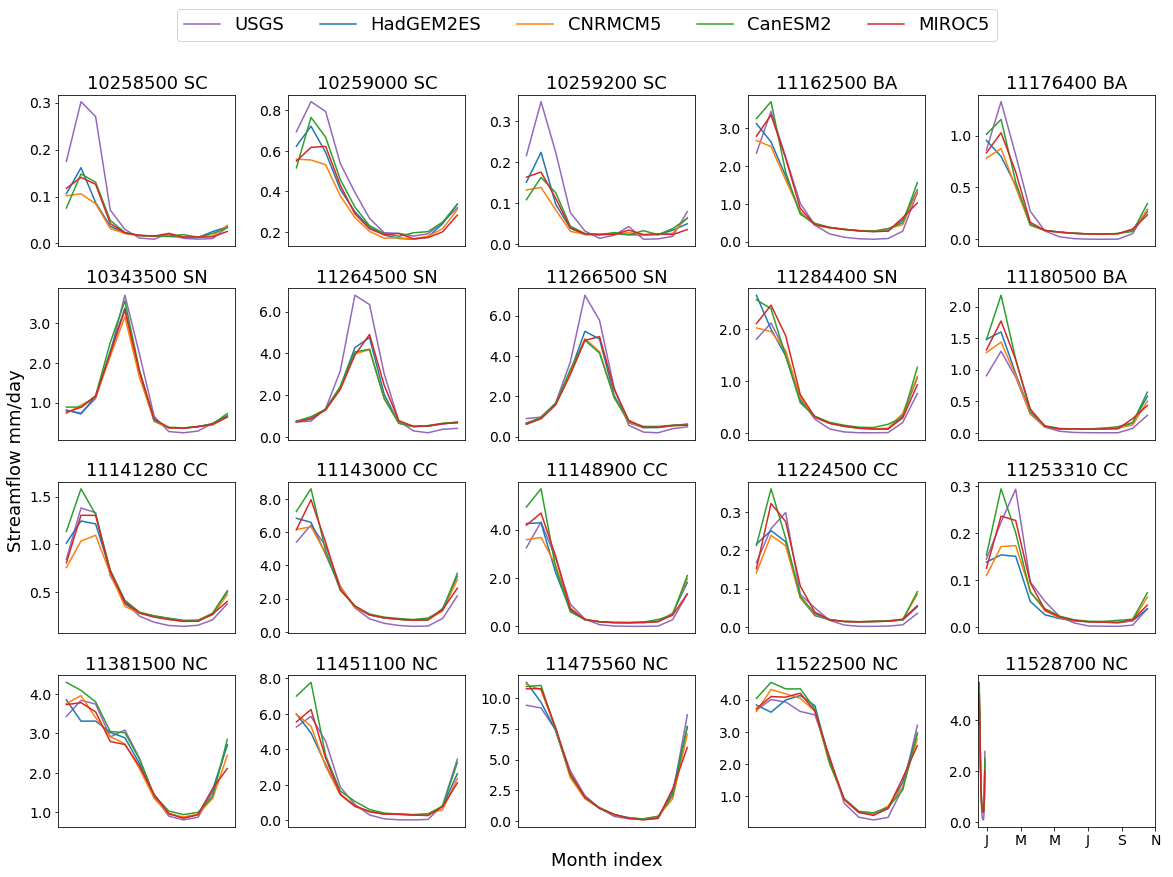

In [94]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Month index")
plt.ylabel("Streamflow mm/day")
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
Hist_date = [start+timedelta(t) for t in hist_date]
i=0

for i in range(20):
    station = order_stations[i]
    flow = np.load('../../usgsflow_'+str(station)+'.npy')[:9498]
    area = areas[str(station)]
    flow = flow*86400*1000/(area*1000*1000)
    flow_date = np.load('../../usgsdate_'+str(station)+'.npy', allow_pickle=True)[:9498]
    out = annual_mean(flow, flow_date)
    # axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs.flat[i].plot(out, label='USGS', c='tab:purple')
    for climate_model in climate_models:
        projection = np.load('projection_dataset/'+str(station)+'-'+climate_model+'-hist.npy')[1:]
        out = annual_mean(projection, Hist_date)
        # print(year)
        axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs.flat[i].plot(out, label=climate_model)
    ## add observation:
    
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    axs.flat[i].set_xticks(month_loc[::2])
    axs.flat[i].set_xticklabels(months[::2])

'''
for ax in axs[:,0]:
    ax.set_ylabel('Streamflow mm/day')
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
'''
handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5) 
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
# fig.savefig('Hist-Streamflow.eps')

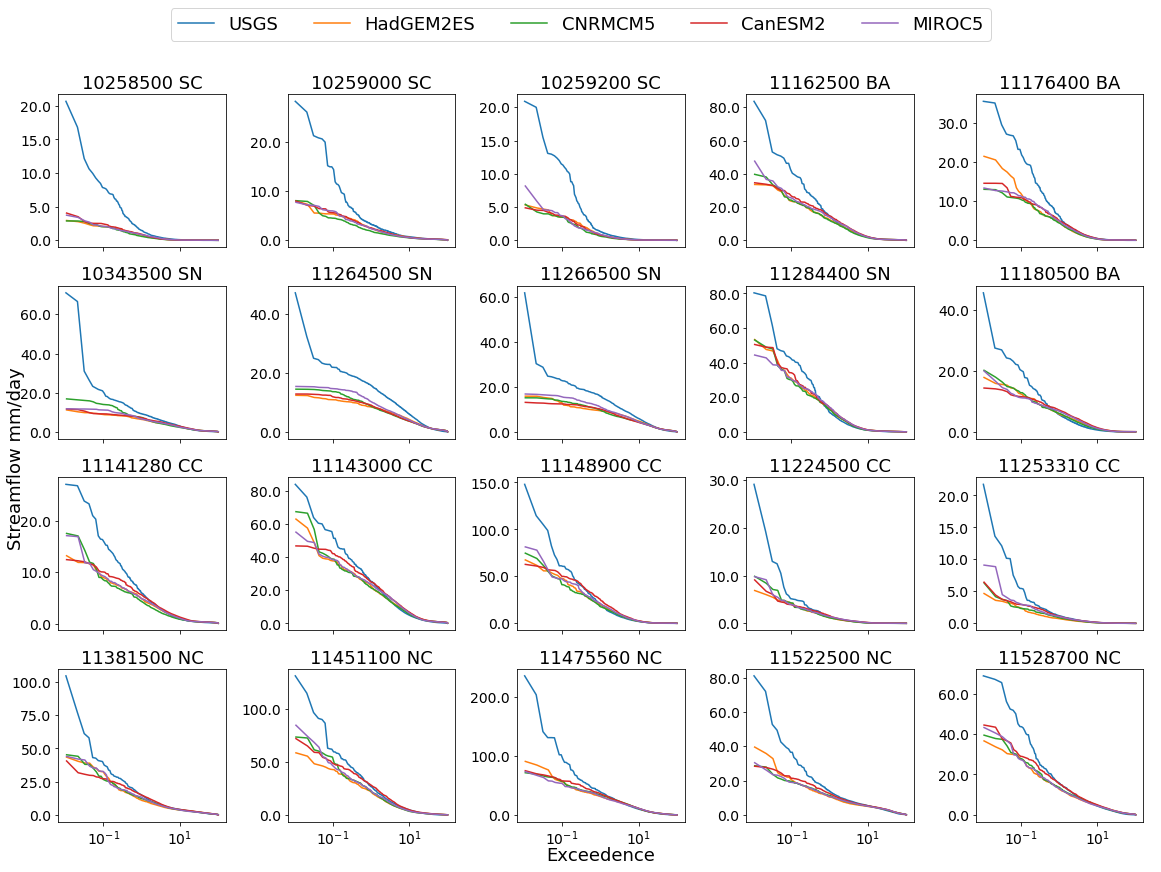

In [92]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Exceedence")
plt.ylabel("Streamflow mm/day")
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
Hist_date = [start+timedelta(t) for t in hist_date]
i=0

for i in range(20):
    station = order_stations[i]
    area = areas[str(station)]
    flow = np.load('../../usgsflow_'+str(station)+'.npy')[:9498]
    flow = flow*86400*1000/(area*1000*1000)
    sort = np.sort(np.clip(flow, a_min=1e-10, a_max=None), axis=None)[::-1]
    exceedence = np.arange(1.,len(sort)+1) / len(sort)
    obs_hist = axs.flat[i].plot(exceedence*100, sort, label='USGS')
    # axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    for climate_model in climate_models:
        projection = np.load('projection_dataset/'+str(station)+'-'+climate_model+'-hist.npy')[1:]
        sort = np.sort(np.clip(projection, a_min=1e-10, a_max=None), axis=None)[::-1]
        exceedence = np.arange(1.,len(sort)+1) / len(sort)
        clim_hist = axs.flat[i].plot(exceedence*100, sort, label=climate_model)
        # print(year)
        axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
    
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    axs.flat[i].set_xscale('log')
    # axs.flat[i].set_yscale('log')
    
    # axs.flat[i].set_xticks(month_loc[::2])
    # axs.flat[i].set_xticklabels(months[::2])

'''
for ax in axs[:,0]:
    ax.set_ylabel('Streamflow mm/day')
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
'''
handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5) 
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
fig.savefig('Hist-FDC.jpg')

## Precipitation compare

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


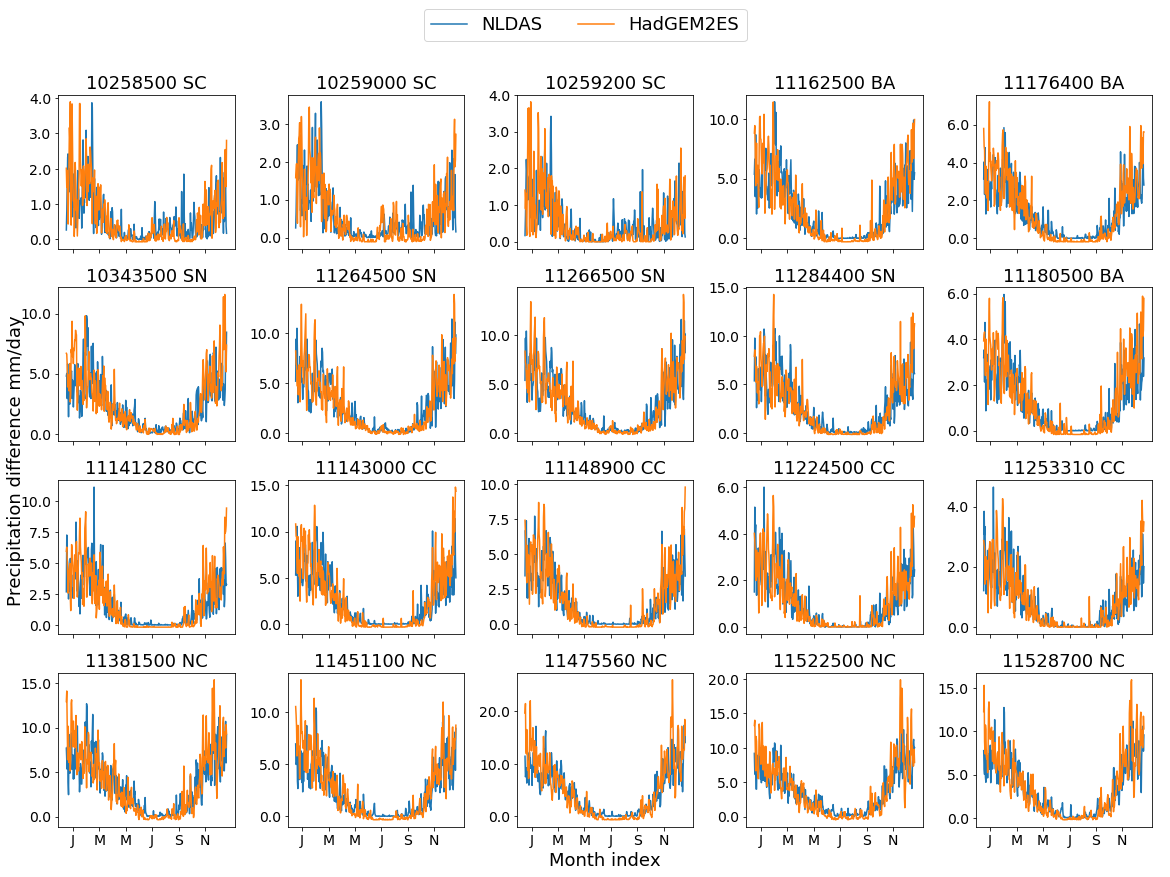

In [98]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
regrid_path = '/tempest/duan0000/flow/tem-remap/regrid_out/'
plt.xlabel("Month index")
plt.ylabel("Precipitation difference mm/day")
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
Hist_date = [start+timedelta(t) for t in hist_date]
i=0

for i in range(20):
    station = order_stations[i]
    ## add observation:
    precip = np.load('../../NLDAS_precip_'+str(station)+'.npy')
    flow_date = np.load('../../usgsdate_'+str(station)+'.npy', allow_pickle=True)
    out0 = annual_mean(precip, flow_date)
    # axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs.flat[i].plot(out0, label='NLDAS')
    # for climate_model in climate_models:
    climate_model='HadGEM2ES'
    p_hist = np.load(regrid_path+str(station)+'_'+climate_model+'_p_hist.npy').reshape(-1, 1)
    out = annual_mean(p_hist, Hist_date)
    axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axs.flat[i].plot(out, label=climate_model)
    
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    axs.flat[i].set_xticks(month_loc[::2])
    axs.flat[i].set_xticklabels(months[::2])

'''
for ax in axs[:,0]:
    ax.set_ylabel('Streamflow mm/day')
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
'''
handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5) 
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
fig.savefig('hist-precip-difference.eps')

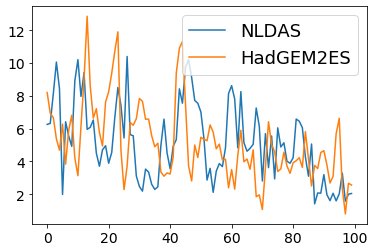

2.343493422458134   2.320530630446079
516.1188034188035   516.5581187682045
2.742410841821801   2.7461409357709385
2.7661344125861578   2.875712193304855


In [65]:
station = 11264500
precip = np.load('../../NLDAS_precip_'+str(station)+'.npy')[:9498]
flow_date = np.load('../../usgsdate_'+str(station)+'.npy', allow_pickle=True)
out0 = annual_mean(precip, flow_date)
# axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(out0[:100], label='NLDAS')
# for climate_model in climate_models:
climate_model='HadGEM2ES'
p_hist = np.load(regrid_path+str(station)+'_'+climate_model+'_p_hist.npy').reshape(-1, 1)
out = annual_mean(p_hist, Hist_date)
plt.plot(out[:100], label=climate_model)
plt.legend()
plt.show()
print(np.std(out0[:100]), ' ', np.std(out[:100]))
print(np.sum(out0[:100]), ' ', np.sum(out[:100]))
print(np.mean(out0), ' ', np.mean(out))
print(np.std(out0), ' ', np.std(out))

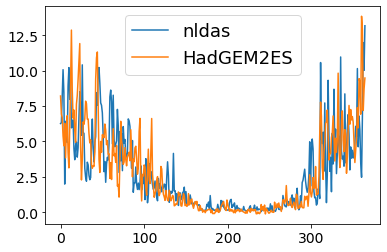

0.0037300939491378806   1.3873616564362963


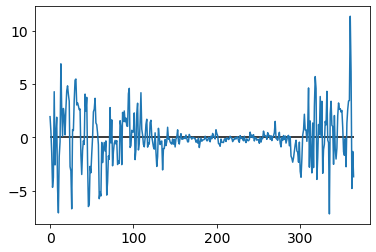

0.0367304926093785   -0.17550238957823297   0.18477934187987058


In [74]:
plt.plot(out0[:], label='nldas')
plt.plot(out[:], label='HadGEM2ES')
plt.legend()
plt.show()
print(np.mean(out-out0), ' ', np.mean(np.abs(out-out0)))

plt.plot(out-out0)
plt.hlines(0, xmin=0, xmax=365)
plt.show()

print(np.mean((out-out0)[:130]), ' ', np.mean((out-out0)[130:260]), ' ', np.mean((out-out0)[260:]))

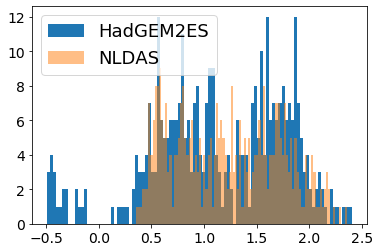

In [72]:
plt.hist(np.cbrt(out), bins=100, label='HadGEM2ES')
plt.hist(np.cbrt(out0), bins=100, label='NLDAS', alpha=0.5)
plt.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


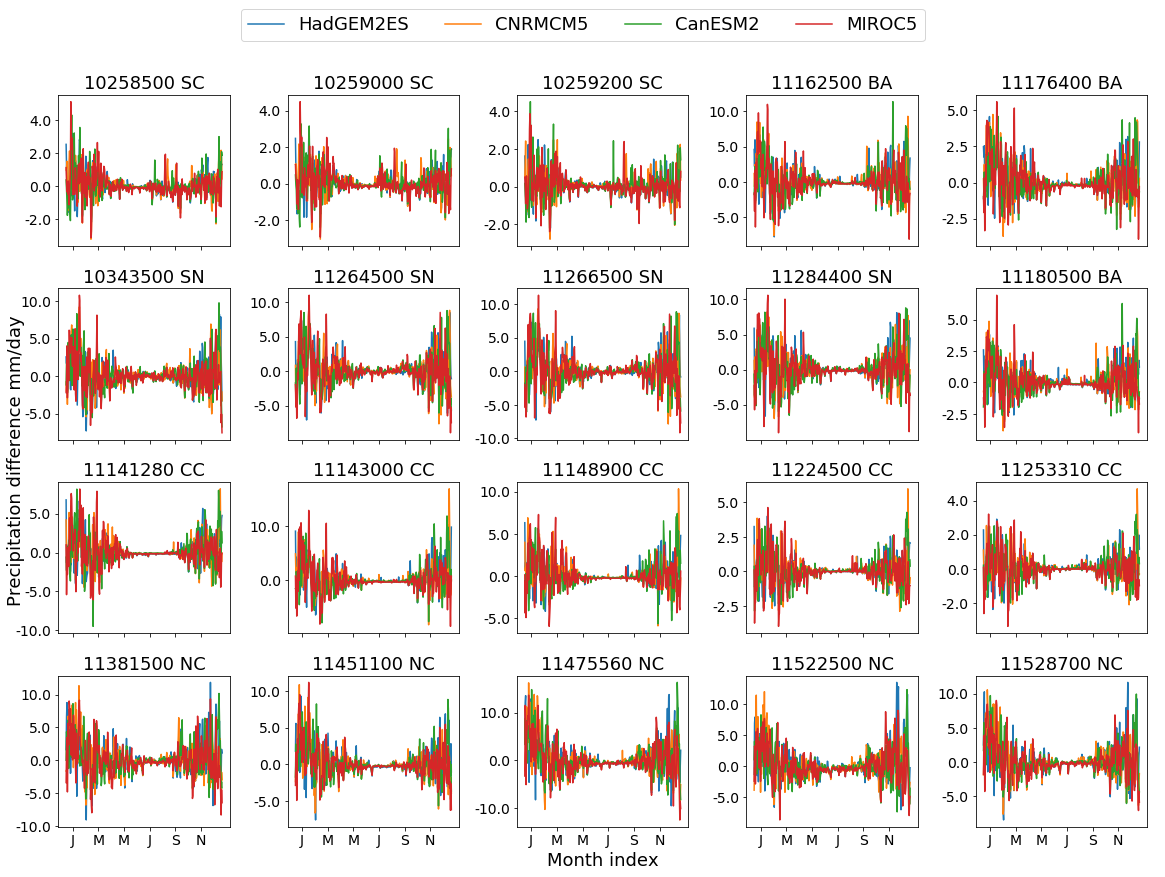

In [109]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
regrid_path = '/tempest/duan0000/flow/tem-remap/regrid_out/'
plt.xlabel("Month index")
plt.ylabel("Precipitation difference mm/day")
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
Hist_date = [start+timedelta(t) for t in hist_date]
i=0

for i in range(20):
    station = order_stations[i]
    ## add observation:
    precip = np.load('../../NLDAS_precip_'+str(station)+'.npy')
    flow_date = np.load('../../usgsdate_'+str(station)+'.npy', allow_pickle=True)
    out0 = annual_mean(precip, flow_date)
    # axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # axs.flat[i].plot(annual, label='NLDAS')
    for climate_model in climate_models:
        p_hist = np.load(regrid_path+str(station)+'_'+climate_model+'_p_hist.npy').reshape(-1, 1)
        out = annual_mean(p_hist, Hist_date)
        axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs.flat[i].plot(out-out0, label=climate_model)
    
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    axs.flat[i].set_xticks(month_loc[::2])
    axs.flat[i].set_xticklabels(months[::2])

'''
for ax in axs[:,0]:
    ax.set_ylabel('Streamflow mm/day')
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
'''
handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5) 
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
fig.savefig('hist-precip-difference.eps')

## Temperature

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


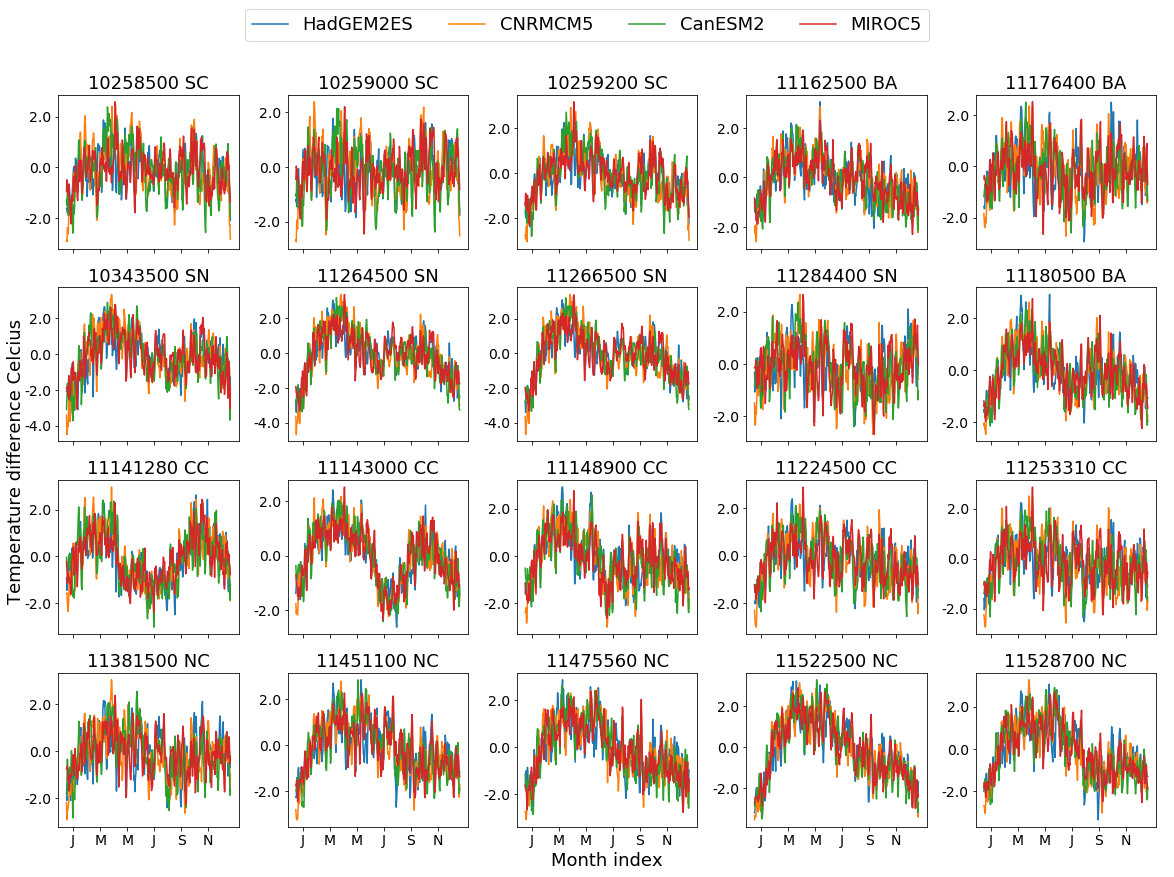

In [116]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
regrid_path = '/tempest/duan0000/flow/tem-remap/regrid_out/'
plt.xlabel("Month index")
plt.ylabel("Temperature difference Celcius")
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
Hist_date = [start+timedelta(t) for t in hist_date]
i=0

for i in range(20):
    station = order_stations[i]
    ## add observation:
    temp = np.load('../../NLDAS_tmax_'+str(station)+'.npy')
    area = areas[str(station)]
    flow_date = np.load('../../usgsdate_'+str(station)+'.npy', allow_pickle=True)
    out0 = annual_mean(temp, flow_date)
    for climate_model in climate_models:
        t_hist = np.load(regrid_path+str(station)+'_'+climate_model+'_t_hist.npy').reshape(-1, 1)
        out = annual_mean(t_hist, Hist_date)
        axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs.flat[i].plot(out-out0, label=climate_model)
    
    # axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    axs.flat[i].set_xticks(month_loc[::2])
    axs.flat[i].set_xticklabels(months[::2])


handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5) 
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
fig.savefig('hist-temperature-difference.eps')

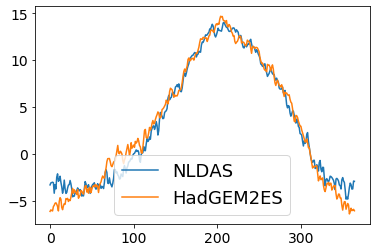

0.0015929602366579051   0.8885819953681834
0.9984097628444264   2.13113
-300.0464957264958   -295.17572
3.3066513288842057   3.305058
6.248004603115211   6.547745


In [86]:
station = 11264500
precip = np.load('../../NLDAS_tmax_'+str(station)+'.npy')[:9498]
flow_date = np.load('../../usgsdate_'+str(station)+'.npy', allow_pickle=True)
out0 = annual_mean(precip, flow_date)
# axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(out0[:], label='NLDAS')
# for climate_model in climate_models:
climate_model='HadGEM2ES'
p_hist = np.load(regrid_path+str(station)+'_'+climate_model+'_t_hist.npy').reshape(-1, 1)
out = annual_mean(p_hist, Hist_date)
plt.plot(out[:], label=climate_model)
plt.legend()
plt.show()
print(np.mean(out0-out), ' ', np.mean(np.abs(out0-out)))
print(np.std(out0[:100]), ' ', np.std(out[:100]))
print(np.sum(out0[:100]), ' ', np.sum(out[:100]))
print(np.mean(out0), ' ', np.mean(out))
print(np.std(out0), ' ', np.std(out))

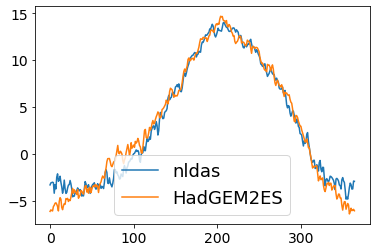

-0.0015929602366579051   0.8885819953681834


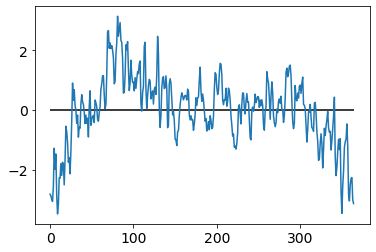

0.2480377661698032   0.11936939900866646   -0.46042249485315423


In [76]:
plt.plot(out0[:], label='nldas')
plt.plot(out[:], label='HadGEM2ES')
plt.legend()
plt.show()
print(np.mean(out-out0), ' ', np.mean(np.abs(out-out0)))

plt.plot(out-out0)
plt.hlines(0, xmin=0, xmax=365)
plt.show()

print(np.mean((out-out0)[:130]), ' ', np.mean((out-out0)[130:260]), ' ', np.mean((out-out0)[260:]))

## Srad

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


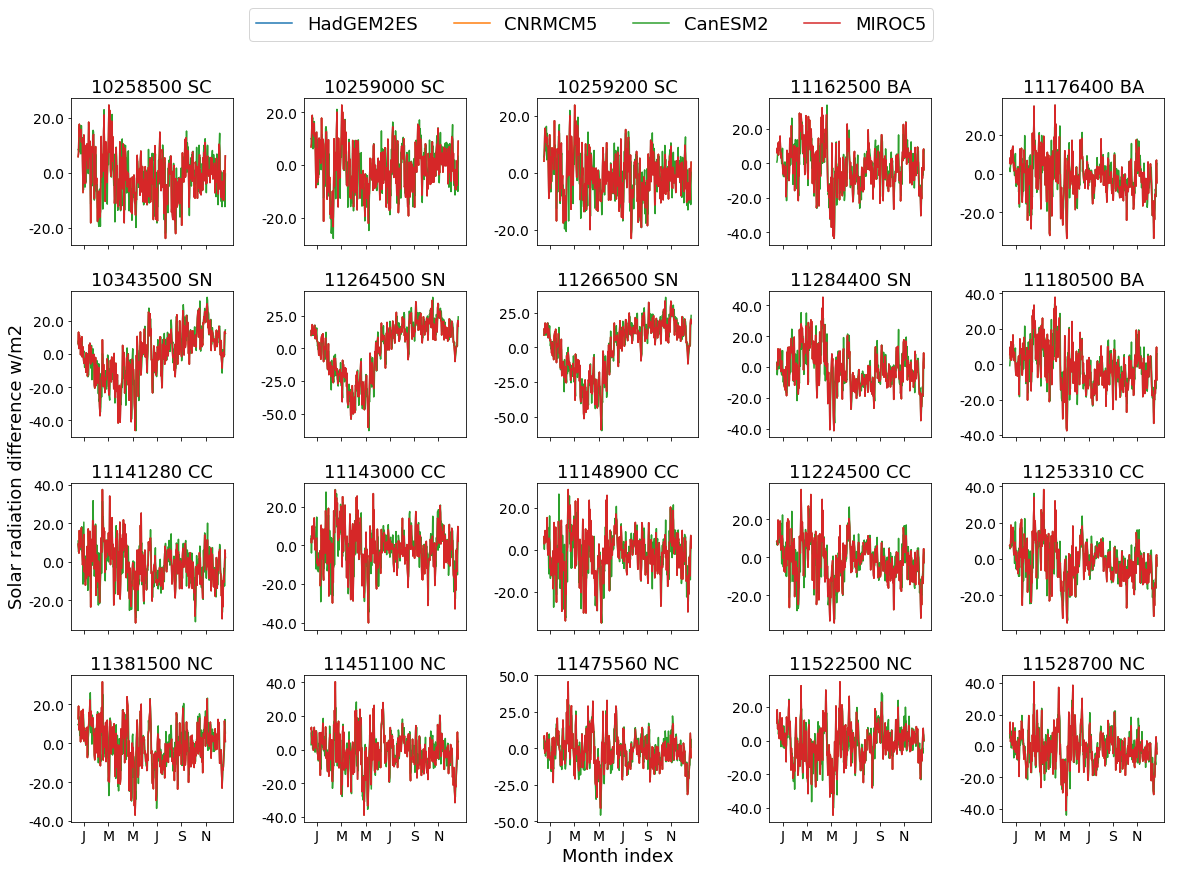

In [113]:
fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=(17,13))
fig.add_subplot(111, frameon=False)
plt.subplots_adjust(left=0.40)
plt.tick_params(labelcolor="none", bottom=False, left=False)
regrid_path = '/tempest/duan0000/flow/tem-remap/regrid_out/'
plt.xlabel("Month index")
# plt.ylabel("Solar radiation difference w/m2")
fig.text(0.03, 0.5, 'Solar radiation difference w/m2', ha='center', va='center', rotation='vertical')
hist_date = Dataset('/tempest/duan0000/flow/tem-remap/LOCA/CanESM2/precip_hist_regrid_6.nc').variables['time'][:]
Hist_date = [start+timedelta(t) for t in hist_date]
i=0

for i in range(20):
    station = order_stations[i]
    ## add observation:
    srad = np.load('../../NLDAS_srad_'+str(station)+'.npy')
    flow_date = np.load('../../usgsdate_'+str(station)+'.npy', allow_pickle=True)
    out0 = annual_mean(srad, flow_date)
    for climate_model in climate_models:
        rs = np.load(regrid_path+str(station)+'_'+climate_model+'_rs_hist.npy').reshape(-1, 1)
        out = annual_mean(rs, Hist_date)
        
        axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axs.flat[i].plot(out-out0, label=climate_model)
    
    # axs.flat[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    axs.flat[i].set_title(str(station)+' '+station_dict[str(station)])
    axs.flat[i].set_xticks(month_loc[::2])
    axs.flat[i].set_xticklabels(months[::2])

'''
for ax in axs[:,0]:
    ax.set_ylabel('Streamflow mm/day')
for ax in axs[-1,:]:
    ax.set_xlabel('Month')
'''
handles, labels = axs.flat[i-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5) 
fig.tight_layout(rect=[0, 0.03, 1, 0.94])
fig.savefig('hist-radiation-difference.eps')